# Data Processing Exercise / Graph Approach - Ali Hodroj

In [106]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

#Display charts inline
%matplotlib inline

filename = "/Users/alihodroj/Downloads/PS_20174392719_1491204439457_log.csv"

## Build a graph and analyze it

In [107]:
# Read as pandas dataframe and check schema 
columns = ['nameOrig','nameDest', 'amount']
df = pd.read_csv(filename)[columns]
df.shape

(6362620, 3)

In [108]:
df.dtypes

nameOrig     object
nameDest     object
amount      float64
dtype: object

In [109]:
# Convert the pandas dataset into a directed graph of (sender -(amount)-> receiver) nodes and edges
G = nx.from_pandas_edgelist(df, source='nameOrig', target='nameDest', edge_attr='amount', create_using=nx.DiGraph())

In [110]:
# Let's check the number of nodes (total # of participants)
G.number_of_nodes()

9073900

In [111]:
# Let's check the number of edges (aka transactions)...Looks like it's the same number as the number of lines (6,362,620) in the file 
# ...which means that there are no bidirectional transactions (i.e. no indication that nameOrig and nameDest both sent AND received transactions to each other)

G.number_of_edges()

6362620

## Largest degree between participants

In [112]:
# Sort all nodes by # of edges with have with other nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[0:5]

[('C1286084959', 113),
 ('C985934102', 109),
 ('C665576141', 105),
 ('C2083562754', 102),
 ('C248609774', 101)]

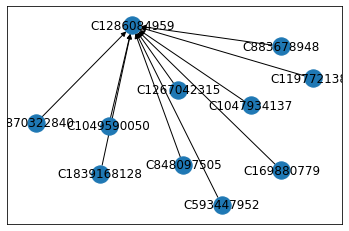

In [113]:
# Let's visualize 10 of the 113 participants who transacted with C1286084959
l = list(G.predecessors('C1286084959'))[0:10]
l.append('C1286084959')
sg = G.subgraph(l)
nx.draw_networkx(sg)


## top 5 transaction subnets by largest amounts of transactions performed between connected participants

In [114]:
receivers = dict((el,0) for el in list(df['nameDest']))
for orig,dest,amt in G.edges(data=True):
    receivers[dest] += amt['amount']
rc = sorted(receivers.items(), key=lambda x:x[1], reverse=True)
rc[0:10]

[('C439737079', 357440831.44),
 ('C707403537', 299374418.4199999),
 ('C167875008', 274736432.8000001),
 ('C20253152', 270116188.69),
 ('C172409641', 255310174.25000003),
 ('C268913927', 253484588.09999996),
 ('C936857833', 227780012.01999998),
 ('C65111466', 227443845.85000002),
 ('C744189981', 225173861.73000002),
 ('C1406193485', 224778961.83)]

## top 10 who serve as cash out hubs

In [115]:
# Let's reload only CASH_OUT edges into a separate graph
cdf = dd.read_csv(filename, blocksize='50MB')
hdf = cdf.loc[cdf["type"] == "CASH_OUT"].compute()
hdf = hdf[['nameOrig','nameDest','amount']]

In [116]:
hdf.shape

(2237500, 3)

In [117]:
H = nx.from_pandas_edgelist(hdf, source='nameOrig', target='nameDest', edge_attr='amount', create_using=nx.DiGraph())

In [118]:
H.number_of_nodes()

2724799

In [119]:
H.number_of_edges()

2237500

In [120]:
receivers = dict((el,0) for el in list(hdf['nameDest']))

In [121]:
for orig,dest,amt in H.edges(data=True):
    receivers[dest] += amt['amount']
rc = sorted(receivers.items(), key=lambda x:x[1], reverse=True)
rc[0:10]

[('C766681183', 16131184.180000003),
 ('C2059078386', 15219699.7),
 ('C150091086', 14654741.55),
 ('C1049795740', 14194980.540000003),
 ('C141316671', 13994935.370000001),
 ('C242619213', 13783198.83),
 ('C779798347', 13332713.57),
 ('C308220962', 13281158.65),
 ('C1990623385', 13238327.84),
 ('C1477641326', 12964861.56)]

# Finding rings of transactions

In [122]:
# Find rings of transactional members where majority (80%) of the money transacted from a participant end up in the same account 
# via a chain of transactions (A->B->C->…->A), get the top 10 by volumes.
# Therefore, we will check for potential cyclical subgraphs in the overall network

# ... no cycles found


In [123]:
dests = list(hdf['nameDest'])

In [124]:
for d in dests:
    try:
        cycle = nx.find_cycle(G, d)
        print(cycle)
    except Exception:
        continue